## Phase 1 To-Do

### [check] 1 tomnod
Write a Python code to read the TOMNOD’s GeoJSON files in

`https://www.digitalglobe.com/opendata/hurricane-harvey/vector-data`

and identify the catalog IDs of the satellite images labeled by Tomnodders. 

### [check] 2 images from S3
Download the relevant satellite images from 

`https://www.digitalglobe.com/opendata/hurricane-harvey/post-event`

### 3 create overlay images
- Write a Python code to create a figure overlaying 
- The satellite images (GeoTIFF format)
- The labels from the GeoJSON files

### 4 find relevant GIS data
- Find other relevant GIS data to leverage (e.g., buildings, roads, other infrastructures) e.g., a map of the Huston metropolitan area (e.g., OpenStreetMap)

### 5 Lit review
- Conduct literature review to learn the state-of-the-art methods to annotate satellite images
- Document your literature review results
- Summary of relevant points
- Synthesis of the articles you skimmed (or read)
- Any pattern you found?
- Any significant gap in the literature?
- Recommendation: Use Google Scholar & cite the article using the APA format.
- Keywords you will (and should) often see
    - Remote sensing
    - Machine learning
    - Supervised & unsupervised learning
    - Computer vision
- Breath vs. Depth: You cannot know it all. You should know enough to use if needed. You can innovate if you know deep enough.



In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 

import geopandas as gpd
import geojson
from shapely import geometry

import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image
import rasterio.mask
import fiona
from descartes import PolygonPatch

from PIL import Image
import requests
from io import BytesIO

import os
import shutil

## get geoJSON file

In [7]:
geojson_file_path = "geoJSON_data/digitalglobe_crowdsourcing_hurricane_harvey_20170915.geojson"
df = gpd.read_file(geojson_file_path)

In [8]:
df.head(2)

,id,tag_id,label,tagger_id,type_id,score,agreement,chip_size,chip_url,timestamp,overlay_id,acquisition_date,sensor,catalog_id,map_id,geometry
0,214149-59,59,Flooded / Damaged Building,30425,226,1.000000,32,None,https://s3.amazonaws.com/explorationlab/chips/...,2017-09-15T22:01:52,60044,2017-08-31T23:39:39,GE01,105001000B95E200,9029,POINT (-95.096374 29.84318)
1,214149-72,72,Flooded / Damaged Building,6294177,226,1.000000,24,None,https://s3.amazonaws.com/explorationlab/chips/...,2017-09-15T22:01:52,60043,2017-08-31T23:39:05,GE01,105001000B95E100,33640,POINT (-95.50154999999999 29.760742)


### create a new dataframe with polygons instead of points
- create a roughly 50 x 50 ft polygon box around each point

https://gis.stackexchange.com/questions/92754/how-can-i-group-points-to-make-polygon-via-python

In [9]:
one_degree_latitude_in_feet_houston = 363688 #http://www.csgnetwork.com/degreelenllavcalc.html
one_degree_longitude_in_feet_houston = 316555

In [10]:
fifty_feet_in_latitude = 1 / (one_degree_latitude_in_feet_houston / 50)
fifty_feet_in_longitude = 1 / (one_degree_longitude_in_feet_houston / 50)

In [11]:
fifty_feet_in_latitude

0.00013748047777215636

In [12]:
fifty_feet_in_longitude

0.00015795043515344883

In [17]:
def get_polygon_df(df):
    df = df.rename(columns={"geometry" : "point_geometry"})
    for idx in df.index:
        point = df['point_geometry'][idx]
        df.loc[idx, "geometry"] = get_polygon_around_point(point)
    df = df.drop("point_geometry", axis=1)
    return df

def get_polygon_around_point(point):
    p1 = geometry.Point(point.x - fifty_feet_in_longitude, point.y+fifty_feet_in_latitude)
    p2 = geometry.Point(point.x - fifty_feet_in_longitude, point.y-fifty_feet_in_latitude)
    p3 = geometry.Point(point.x +fifty_feet_in_longitude , point.y-fifty_feet_in_latitude)
    p4 = geometry.Point(point.x +fifty_feet_in_longitude, point.y+fifty_feet_in_latitude)
    pointList = [p1, p2, p3, p4, p1]
    poly = geometry.Polygon([[p.x, p.y] for p in pointList])
    return poly

In [14]:
df_poly = get_polygon_df(df)

In [15]:
df_poly.head() # see last column "geometry" is polygons instead of points

,id,tag_id,label,tagger_id,type_id,score,agreement,chip_size,chip_url,timestamp,overlay_id,acquisition_date,sensor,catalog_id,map_id,geometry
0,214149-59,59,Flooded / Damaged Building,30425,226,1.000000,32,None,https://s3.amazonaws.com/explorationlab/chips/...,2017-09-15T22:01:52,60044,2017-08-31T23:39:39,GE01,105001000B95E200,9029,POLYGON ((-95.09653195043515 29.84331748047777...
1,214149-72,72,Flooded / Damaged Building,6294177,226,1.000000,24,None,https://s3.amazonaws.com/explorationlab/chips/...,2017-09-15T22:01:52,60043,2017-08-31T23:39:05,GE01,105001000B95E100,33640,POLYGON ((-95.50170795043515 29.76087948047777...
2,214149-76,76,Flooded / Damaged Building,6294177,226,1.000000,20,None,https://s3.amazonaws.com/explorationlab/chips/...,2017-09-15T22:01:52,60043,2017-08-31T23:39:05,GE01,105001000B95E100,28027,POLYGON ((-95.50556495043516 29.75235748047777...
3,214149-108,108,Flooded / Damaged Building,6294177,226,1.000000,28,None,https://s3.amazonaws.com/explorationlab/chips/...,2017-09-15T22:01:52,60043,2017-08-31T23:39:05,GE01,105001000B95E100,32835,POLYGON ((-95.52209895043515 29.74852348047777...
4,214149-111,111,Flooded / Damaged Building,6294177,226,1.000000,25,None,https://s3.amazonaws.com/explorationlab/chips/...,2017-09-15T22:01:52,60043,2017-08-31T23:39:05,GE01,105001000B95E100,32835,POLYGON ((-95.52272595043516 29.74873348047777...


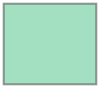

In [16]:
df_poly['geometry'][0] # in this dataframe, the geometry is all Polygons instead of points

### find catalog IDs of interest

view digital globe image at https://discover.digitalglobe.com/14fee608-061d-11e8-b425-0242ac110002

In [10]:
df.groupby('catalog_id').count()

,id,tag_id,label,tagger_id,type_id,score,agreement,chip_size,chip_url,timestamp,overlay_id,acquisition_date,sensor,map_id,geometry
catalog_id,,,,,,,,,,,,,,,
1040010032211E00,2108,2108,2108,2108,2108,2108,2108,0,2108,2108,2108,2108,2108,2108,2108
105001000B95E100,10564,10564,10564,10564,10564,10564,10564,0,10564,10564,10564,10564,10564,10564,10564
105001000B95E200,3988,3988,3988,3988,3988,3988,3988,0,3988,3988,3988,3988,3988,3988,3988


In [275]:
catalog_ids = list(df.groupby('catalog_id').count().index[:3])

In [276]:
catalog_ids

['1040010032211E00', '105001000B95E100', '105001000B95E200']

### what's up with chip_urls?

In [75]:
grouped = df.groupby('chip_url').count()

In [76]:
grouped.sort_values(by='id', ascending=False)

,id,tag_id,label,tagger_id,type_id,score,agreement,chip_size,timestamp,overlay_id,acquisition_date,sensor,catalog_id,map_id,geometry
chip_url,,,,,,,,,,,,,,,
https://s3.amazonaws.com/explorationlab/chips/0000a25c744381d7c0d25a977067aa63.jpg,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
https://s3.amazonaws.com/explorationlab/chips/aa8ee8fd91653c15eeacdf2c46b1bb5b.jpg,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
https://s3.amazonaws.com/explorationlab/chips/aaa34f9e04fd352a30b456d9eb3709f7.jpg,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1
https://s3.amazonaws.com/explorationlab/chips/aaa337be4f9de886dfa3822593baa76f.jpg,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
https://s3.amazonaws.com/explorationlab/chips/aa9b5c5022719645f5c31310501ee285.jpg,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1
https://s3.amazonaws.com/explorationlab/chips/aa9818430d9b624d2ecc07248999d8d5.jpg,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
https://s3.amazonaws.com/explorationlab/chips/aa95f5f19381defc50816a0c1a286378.jpg,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
https://s3.amazonaws.com/explorationlab/chips/aa9345dfbca84ea4ba61906ee41137f5.jpg,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
https://s3.amazonaws.com/explorationlab/chips/aa91ec967e2edd94dee273329ff944b6.jpg,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1


## save shapefiles (.shp) for each 'label' in the geoJSON file

In [4]:
def get_labels(df):
    labels = set(df['label'].values)
    return labels

def save_shapefiles(df, labels, type_of_feature="polygons"):
    for label in labels:
        df_to_save = df[df['label'] == label]
        labels_no_slash.append(label.replace('/', '').replace(' ', '_'))
        df_to_save.to_file("shapefiles/{}/{}".format(type_of_feature, labels_no_slash[-1])) # see below for supported file types, default is ESRI shapefile

In [89]:
fiona.supported_drivers # FYI - formats that the geopandas to_file method supports writing to

{'ARCGEN': 'r',
 'AeronavFAA': 'r',
 'BNA': 'raw',
 'DGN': 'raw',
 'DXF': 'raw',
 'ESRI Shapefile': 'raw',
 'GPKG': 'rw',
 'GPSTrackMaker': 'raw',
 'GPX': 'raw',
 'GeoJSON': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'OpenFileGDB': 'r',
 'PCIDSK': 'r',
 'SEGY': 'r',
 'SUA': 'r'}

In [5]:
labels = get_labels(df)

NameError: name 'df' is not defined

In [31]:
labels

{'Blocked Bridge',
 'Flooded / Blocked Road',
 'Flooded / Damaged Building',
 'Trash Heap'}

### get point shape files

In [95]:
# save_shapefiles(df, labels)

### get polygon shape files

In [26]:
# save_shapefiles(df_poly, labels)

Exception ignored in: <bound method Collection.__del__ of <open Collection '/Users/marybarnes/disaster_data_science/dds_lab/shapefiles/polygon/Trash_Heap:Trash_Heap', mode 'w' at 0x112c5c748>>
Traceback (most recent call last):
  File "/Users/marybarnes/anaconda/envs/dds/lib/python3.6/site-packages/fiona/collection.py", line 426, in __del__
    self.close()
  File "/Users/marybarnes/anaconda/envs/dds/lib/python3.6/site-packages/fiona/collection.py", line 403, in close
    self.flush()
  File "/Users/marybarnes/anaconda/envs/dds/lib/python3.6/site-packages/fiona/collection.py", line 393, in flush
    self.session.sync(self)
  File "fiona/ogrext.pyx", line 1059, in fiona.ogrext.WritingSession.sync
ValueError: Null data source


## download images (caution! over 120GB!)
view smaller image at https://discover.digitalglobe.com/14fee608-061d-11e8-b425-0242ac110002


remove "break" lines to run in entirety

In [27]:
def create_url_file_paths(catalog_ids):
    cwd = os.getcwd()
    return ["{}/images/{}/all_links.txt".format(cwd, catalog_ids[1]) for id in catalog_ids]

In [268]:
def download_and_save_images_in_file_paths(url_file_paths):
    for x in range(len(url_file_paths)):
        with open(url_file_paths[x]) as f:
            urls = f.readlines()
        for url in urls:
            url = url.rstrip()
            path = url_file_paths[x][:63] + url[88:]
            download_and_save_image(url, path)
            break
        break

In [270]:
def download_and_save_image(url, path):
    print(repr(url))
    r = requests.get(url, stream=True)
    print("status code was: {}".format(r.status_code))
    if r.status_code == 200:
        with open(path, 'wb') as f:
            for chunk in r.iter_content(chunk_size = 1024):
                if chunk:
                    f.write(chunk)
#             r.raw.decode_content = True
#             shutil.copyfileobj(r.raw, f) 
            print("Successfully downloaded")

In [19]:
catalog_ids = list(df.groupby('catalog_id').count().index[:3])

In [246]:
catalog_ids

['1040010032211E00', '105001000B95E100', '105001000B95E200']

In [28]:
url_file_paths = create_url_file_paths(catalog_ids)

In [29]:
url_file_paths

['/Users/marybarnes/disaster_data_science/images/105001000B95E100/all_links.txt',
 '/Users/marybarnes/disaster_data_science/images/105001000B95E100/all_links.txt',
 '/Users/marybarnes/disaster_data_science/images/105001000B95E100/all_links.txt']

In [271]:
download_and_save_images_in_file_paths(url_file_paths)

'http://opendata.digitalglobe.com/hurricane-harvey/post-event/2017-08-31/105001000B95E100/2113313.tif'
status code was: 
Successfully downloaded


# geoTIFF files with rasterio

#### working with a single TIFF because I don't have space to download all

In [18]:
cwd = os.getcwd()
single_tif_file_path = "{}/../images/3020013.tif".format(cwd)

#### open the image with rasterio

In [19]:
dataset = rasterio.open(single_tif_file_path)

### bands
A dataset band is an array of values representing the partial distribution of a single variable in 2-dimensional (2D) space. 
All band arrays of a dataset have the same number of rows and columns. 

In [150]:
dataset.count # we have three 'bands'

3

In [286]:
dataset.shape

(19584, 19584)

In [153]:
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)} # all dtypes are uint8

{1: 'uint8', 2: 'uint8', 3: 'uint8'}

### bounds

In [154]:
dataset.bounds # we have the lat lon coordinates! yay!

BoundingBox(left=-95.361328125, bottom=29.619140625, right=-95.2734375, top=29.70703125)

### georeferencing with tiff files and rasterio
- The transform attribute (below) is an affine transformation matrix  that maps pixel locations in (row, col) coordinates to (x, y) spatial positions. 
- The product of this matrix and (0, 0), the row and column coordinates of the upper left corner of the dataset, is the spatial position of the upper left corner.
- The Affine object is a named tuple with elements a, b, c, d, e, f corresponding to the elements in the matrix equation below, in which a pixel’s image coordinates are x, y and its world coordinates are x', y'.:

`| x' |   | a b c | | x |
| y' | = | d e f | | y |
| 1  |   | 0 0 1 | | 1 |`

In [287]:
dataset.affine

Affine(4.487879136029412e-06, 0.0, -95.361328125,
       0.0, -4.487879136029412e-06, 29.70703125)

### coordinate reference system/georeferencing
Coordinate reference systems are an advanced topic. Suffice it to say that between the 
crs attribute and the transform attribute a raster dataset  is geo-referenced and can be compared to other GIS datasets.
- There are two parts to the georeferencing of raster datasets: the definition of the local, regional, or global system in which a raster’s pixels are located; and the parameters by which pixel coordinates are transformed into coordinates in that system.

In [156]:
dataset.crs

CRS({'init': 'epsg:4326'})

### 'reading' the dataset
compare 'shape' above and below

In [20]:
raster = dataset.read()

In [289]:
raster.shape # now we have all three bands 

(3, 19584, 19584)

In [290]:
type(raster) # now it's just a regular old numpy array without a georeferending system

numpy.ndarray

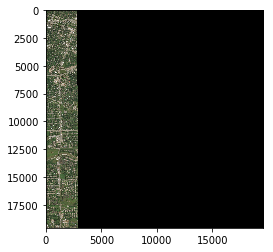

In [21]:
rasterio.plot.show(raster) # rasterio has built in plotting function that uses matplotlib

### reshaping image for use with other python libraries (matplotlib)
Some python image processing software packages organize arrays differently than rasterio. The interpretation of a 3-dimension array read from rasterio is:

`(bands, rows, columns)`

while image processing software like scikit-image, pillow and matplotlib are generally ordered:

`(rows, columns, bands)`

The number of rows defines the dataset’s height, the columns are the dataset’s width.

Numpy provides a way to efficiently swap the axis order and you can use the following reshape functions to convert between raster and image axis order:

In [23]:
plt_image = reshape_as_image(raster)
plt_image.shape

(19584, 19584, 3)

In [161]:
raster2 = reshape_as_raster(plt_image)
raster2.shape

(3, 19584, 19584)

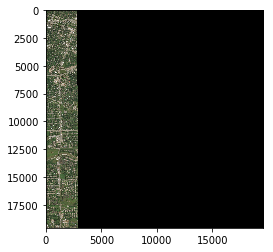

In [24]:
plt.imshow(plt_image)

## masking shapefiles onto geoTIFF with rasterio and fiona

#### create 'features' from the shapefiles we downloaded earlier

In [1]:
def get_features(shape="polygons", label="Flooded__Blocked_Road"):
    shapefile_path= "shapefiles/{}/{}/{}.shp".format(shape, label, label)
    with fiona.open(shapefile_path, "r") as shapefile:
        features = [feature["geometry"] for feature in shapefile]
    return features

In [2]:
def print_features(shape="polygons", label="Flooded__Blocked_Road"):
    shapefile_path= "shapefiles/{}/{}/{}.shp".format(shape, label, label)
    with fiona.open(shapefile_path, "r") as shapefile:
        features = [feature["geometry"] for feature in shapefile]
        print(features)

In [8]:
print_features()

[{'type': 'Polygon', 'coordinates': [[(-95.53606695043516, 29.746730480477773), (-95.53575104956485, 29.746730480477773), (-95.53575104956485, 29.74645551952223), (-95.53606695043516, 29.74645551952223), (-95.53606695043516, 29.746730480477773)]]}, {'type': 'Polygon', 'coordinates': [[(-95.53844895043515, 29.74767648047777), (-95.53813304956485, 29.74767648047777), (-95.53813304956485, 29.747401519522228), (-95.53844895043515, 29.747401519522228), (-95.53844895043515, 29.74767648047777)]]}, {'type': 'Polygon', 'coordinates': [[(-95.53870095043516, 29.74849148047777), (-95.53838504956485, 29.74849148047777), (-95.53838504956485, 29.748216519522227), (-95.53870095043516, 29.748216519522227), (-95.53870095043516, 29.74849148047777)]]}, {'type': 'Polygon', 'coordinates': [[(-95.54168395043516, 29.747742480477772), (-95.54136804956485, 29.747742480477772), (-95.54136804956485, 29.74746751952223), (-95.54168395043516, 29.74746751952223), (-95.54168395043516, 29.747742480477772)]]}, {'type': 

In [10]:
road_features = get_features()
bridge_features = get_features(label="Blocked_Bridge")
trash_features = get_features(label="Trash_Heap")
building_features = get_features(label="Flooded__Damaged_Building")

In [11]:
type(building_features)

list

In [12]:
len(building_features)

18474

In [203]:
len(road_features)

2986

In [204]:
len(trash_features)

113

In [205]:
len(bridge_features)

30

### creating a 'mask' from the features

- currently trying to understand filled, all_touched and invert parameters:
https://mapbox.github.io/rasterio/topics/masking-by-shapefile.html

In [314]:
out_image, out_transform = rasterio.mask.mask(dataset, building_features, 
                                              invert=False, all_touched=True)
out_meta = dataset.meta.copy() # to be used to save the file..see below

In [282]:
dataset.affine

Affine(4.487879136029412e-06, 0.0, -95.361328125,
       0.0, -4.487879136029412e-06, 29.70703125)

In [207]:
out_transform

Affine(4.487879136029412e-06, 0.0, -95.361328125,
       0.0, -4.487879136029412e-06, 29.70703125)

In [300]:
out_image

masked_array(
  data=[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],
  mask=[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False

In [208]:
type(out_image)

numpy.ma.core.MaskedArray

In [293]:
type(out_image.data)

numpy.ndarray

In [294]:
type(out_image.mask)

numpy.ndarray

In [226]:
out_image.shape # same as the raster, same as out_image.data.shape and out_image.mask.shape

(3, 19584, 19584)

In [308]:
np.count_nonzero(out_image) # 6 / 3 = 2 ...could this be the number of buildings overlapping this dataset?

6

In [313]:
np.count_nonzero(out_image) / out_image.shape[0]

2.0

In [316]:
np.count_nonzero(out_image.mask)

0

In [317]:
np.nonzero(out_image.data) # the indices of the 2 non-zero points (2 in each band)

(array([0, 0, 1, 1, 2, 2]),
 array([19100, 19106, 19100, 19106, 19100, 19106]),
 array([2388, 2403, 2388, 2403, 2388, 2403]))

In [306]:
out_image.data[0,19106,2403] 

197

In [307]:
raster[0,19106,2403] # corresponds to the pixel data in the raster (original non-masked dataset)

197

### save the raster (not sure if this makes sense for us...but maybe it will come in handy)

In [ ]:
# out_filepath = 
# out_meta.update({"driver": "GTiff",
#                  "height": out_image.shape[1],
#                  "width": out_image.shape[2],
#                  "transform": out_transform})
# with rasterio.open(out_filepath, "w", **out_meta) as dest:
#     dest.write(out_image)

## one way to plot just the points

In [321]:
banded_points = np.nonzero(out_image.data)

In [332]:
number_of_points = banded_points[0].size // 3

In [334]:
x_coordinates = banded_points[1][0:number_of_points]
y_coordinates = banded_points[2][0:number_of_points]

In [335]:
x_coordinates

array([19100, 19106])

In [336]:
y_coordinates

array([2388, 2403])

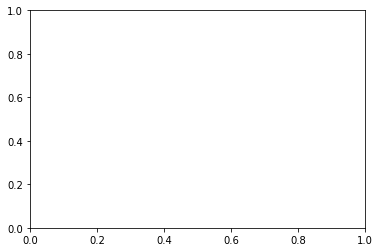

In [338]:
f, ax = plt.subplots()

In [340]:
rasterio.plot.show(raster, ax=ax[0])

TypeError: 'AxesSubplot' object does not support indexing

## code to plot polygons

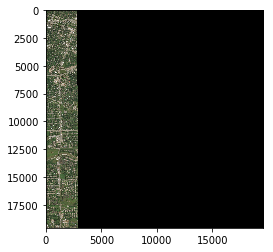

In [26]:
from matplotlib.collections import PatchCollection

plt.imshow(plt_image)
ax = plt.gca()
patches = [PolygonPatch(feature) for feature in road_features]
ax.add_collection(PatchCollection(patches))
plt.show()

### trying to understand the three different bands...

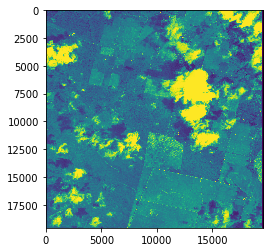

In [64]:
plt.imshow(image[:,:,0])

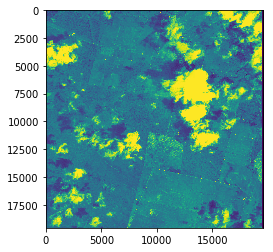

In [65]:
plt.imshow(image[:,:,1])

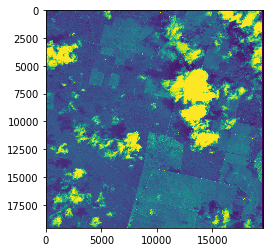

In [66]:
plt.imshow(image[:,:,2])

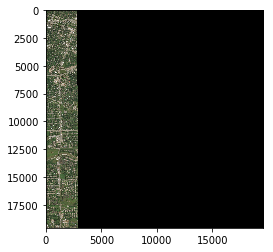

In [369]:
plt.imshow(image[:,:,:])

In [69]:
image[:,:,0]

array([[44, 54, 54, ...,  0,  0,  0],
       [40, 58, 59, ...,  0,  0,  0],
       [52, 50, 59, ...,  0,  0,  0],
       ...,
       [69, 74, 75, ...,  0,  0,  0],
       [74, 79, 85, ...,  0,  0,  0],
       [74, 85, 78, ...,  0,  0,  0]], dtype=uint8)

In [70]:
image[:,:,1]

array([[51, 60, 61, ...,  0,  0,  0],
       [47, 65, 66, ...,  0,  0,  0],
       [58, 57, 66, ...,  0,  0,  0],
       ...,
       [77, 82, 83, ...,  0,  0,  0],
       [82, 88, 93, ...,  0,  0,  0],
       [82, 94, 87, ...,  0,  0,  0]], dtype=uint8)

In [71]:
image[:,:,2]

array([[34, 41, 41, ...,  0,  0,  0],
       [30, 44, 45, ...,  0,  0,  0],
       [38, 38, 44, ...,  0,  0,  0],
       ...,
       [41, 45, 46, ...,  0,  0,  0],
       [45, 49, 53, ...,  0,  0,  0],
       [45, 53, 48, ...,  0,  0,  0]], dtype=uint8)